# Homework4: Denoising score matching

## Task 1: Theory (6pt)

### Problem 1: Frechet Inception Distance  (2pt)
Let prove the theorem from the lecture 6.
Remember the Wasserstein metric:
$$
    W_s(\pi, p) = \inf_{\gamma \in \Gamma(\pi, p)} \left(\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \gamma} \| \mathbf{x} - \mathbf{y} \|^s\right)^{1/s}
$$

Consider the case $\mathbf{x} \sim \pi(\mathbf{x}) = \mathcal{N}(\boldsymbol{\mu}_1, \sigma_1^2 \mathbf{I})$, $\mathbf{y} \sim p(\mathbf{y}) = \mathcal{N}(\boldsymbol{\mu}_2, \sigma_2^2 \mathbf{I})$.

Let prove that in this case
$$
    W_2^2(\pi, p) = \inf_{\gamma \in \Gamma(\pi, p)} \mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \gamma} \| \mathbf{x} - \mathbf{y} \|^2 = \| \boldsymbol{\mu}_1 - \boldsymbol{\mu}_2 \|^2 + m \cdot (\sigma_1 - \sigma_2)^2.
$$
Here $m$ is a dimensionality of the space ($\mathbf{x}, \mathbf{y} \in \mathbb{R}^m$).

**Hints:** (one of the possible solutions)
1. Consider the case $\boldsymbol{\mu}_1 = \boldsymbol{\mu}_2 = 0$.
2. Use Cauchy–Schwarz inequality to prove that the value given above is a minimal.
2. Find the analytical mapping between $\mathbf{x}$ and $\mathbf{y}$ that gives this value.

```
your solution
```

### Problem 2: Implicit score matching (2pt)

We have discussed score matching task at lectures 7 and 8. The objective of score matching is
$$
    \frac{1}{2} \mathbb{E}_{\pi}\bigl\| \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}) - \nabla_\mathbf{x} \log \pi(\mathbf{x}) \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}.
$$

And we have already known one possible solution for this task. It is denoising score matching.

Here our goal is to derive one more way to solve the initial score matching problem. It is called **implicit score matching**.

Let consider 1-d case ($x \in \mathbb{R}$).
Prove that
$$
\frac{1}{2} \mathbb{E}_{\pi}\bigl\| s_{\boldsymbol{\theta}}(x) - \nabla_x \log \pi(x) \bigr\|^2_2 = \mathbb{E}_{\pi}\left[ \frac{1}{2}s^2_{\boldsymbol{\theta}}(x) + \nabla_{x} s_{\boldsymbol{\theta}}(x) \right] + \text{const}.
$$

- **Question:** Why is the expression at the right hand side better than the left one?
  
  **Answer:** It is better because we do not have the term with the unknown distribution $\pi(x)$.

- **Question:** Why do we not use this expression instead of denoising score matching?

  **Answer:** In this expression we have term $\nabla_{x} s_{\boldsymbol{\theta}}(x) = \nabla^2_{x} \log p(x | \boldsymbol{\theta})$. And it is difficult to work with the second derivates.

- **Question:** Why do we consider only 1-d case?

  **Answer:** It is very straightforward to generalize this formula to the multidimensional case, but the derivation contains much more formulas.

```
your solution
```

### Problem 3: Conditioned reverse distribution for NCSN (2pt)

The distribution $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0)$ plays the crucial role in the DDPM.

Find the parameters of this Normal distribution for the NCSN Markov chain $\mathbf{x}_t = \mathbf{x}_0 + \sigma_t \cdot \boldsymbol{\epsilon}$.

**Note:** in this case the mean should be the convex combination of $\mathbf{x}_t$ and $\mathbf{x}_0$ (this differs from the DDPM Markov chain).

```
your solution
```

In [ ]:
COMMIT_HASH = "0d2dec67e0cbddea003cc24d3d46294614c964e4"
!if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!pip install ./
%cd ./..
!rm -Rf dgm_utils

Cloning into 'dgm_utils'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 188 (delta 122), reused 83 (delta 43), pack-reused 0 (from 0)
Receiving objects: 100% (188/188), 41.78 KiB | 10.44 MiB/s, done.
Resolving deltas: 100% (122/122), done.
/content/dgm_utils
Note: switching to '0d2dec67e0cbddea003cc24d3d46294614c964e4'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 0d2dec6 Fix gray images
Processing /c

In [37]:
from dgm_utils import train_model
from dgm_utils import show_samples, visualize_images, load_dataset, visualize_2d_data, visualize_2d_samples
from dgm_utils import BaseModel

In [38]:
import numpy as np
from typing import Tuple, List
import math

import torch
import torch.nn as nn
import torch.utils.data as data

if torch.cuda.is_available():
    DEVICE = "cuda"
    print('GPU found :)')
else:
    DEVICE = "cpu"
    print('GPU not found :(')

GPU found :)


## Task 2: Denoising score matching for 2D data (4 pts)

In this task you will implement the denoising score matching model to the 2D moons dataset.

Let's take a look at dataset samples.

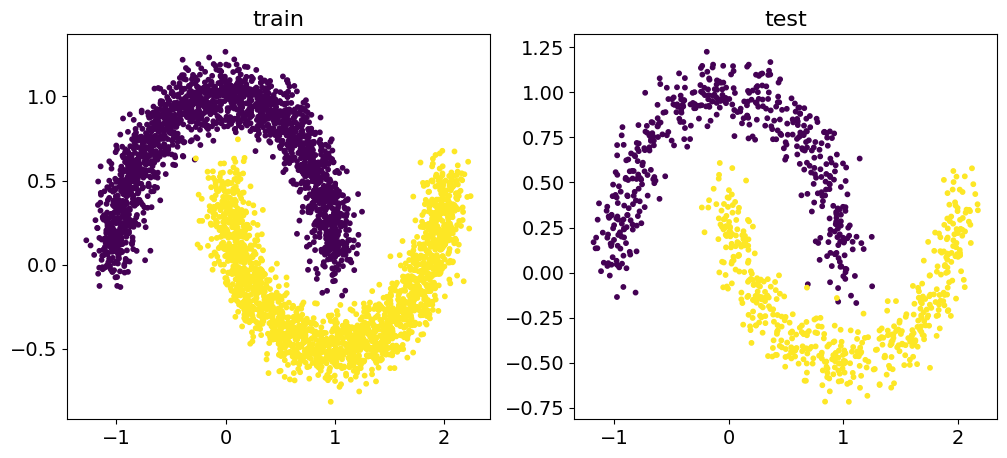

In [39]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = load_dataset('moons', size=COUNT, with_targets=True)
visualize_2d_data(train_data, test_data, train_labels, test_labels)

Let recall the theory of denoising score matching.

The idea is the following. We define the score function
$$
    \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}) = \nabla_{\mathbf{x}}\log p(\mathbf{x}| \boldsymbol{\theta}).
$$

Then we minimize the Fisher divergence to obtain the score function:
$$
    D_F(\pi, p) = \frac{1}{2}\mathbb{E}_{\pi}\bigl\| \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}) - \nabla_{\mathbf{x}} \log \pi(\mathbf{x}) \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}
$$.

If we have the score function, we use the Langevin dynamics to sample from our model:
$$
    \mathbf{x}_{l + 1} = \mathbf{x}_l + \frac{\eta}{2} \cdot \nabla_{\mathbf{x}_l} \log p(\mathbf{x}_l | \boldsymbol{\theta}) + \sqrt{\eta} \cdot \boldsymbol{\epsilon}, \quad \boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I}).
$$

But Fisher divergence is intractable and we use the noising procedure to get noised samples $\mathbf{x}_{\sigma} = \mathbf{x} + \sigma \cdot \boldsymbol{\epsilon}$.

Minimizing the Fisher divergence for the noisy samples is equivalent to the following objective:
$$
\mathbb{E}_{q(\mathbf{x}_{\sigma})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_{\sigma}) \bigr\|^2_2 = \mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_{\sigma} | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_{\sigma} | \mathbf{x}) \bigr\|^2_2 + \text{const}(\boldsymbol{\theta}).
$$

Here
$$
    \log q(\mathbf{x}_{\sigma} | \mathbf{x}) = - \frac{\mathbf{x}_{\sigma} - \mathbf{x}}{\sigma^2} = - \frac{\boldsymbol{\epsilon}}{\sigma}.
$$

Therefore, the objective of the denoising score matching is

$$
\mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_{\sigma} | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) + \frac{\boldsymbol{\epsilon}}{\sigma} \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}.
$$

In [53]:
class DenoisingScoreMatcher(BaseModel):
    def __init__(
            self,
            score_model: nn.Module,
            input_shape: Tuple[int],
            sigma: float
        ):
        super().__init__()

        self.score_model = score_model
        self.input_shape = input_shape
        self.sigma = sigma

    def forward(self, x: torch.Tensor):
        # ====
        # your code
        # sample gaussian noise
        # perturb samples using the noise and sigma
        noise = torch.randn_like(x)
        noisy_x = x + self.sigma * noise
        # =====

        # calculate the score model
        s = self.score_model(noisy_x)
        # ====
        # your code
        # compute the loss
        # it is mse between score function and gradient of the normal distribution
        loss = nn.functional.mse_loss(s, -noise / self.sigma, reduction='none')
        # =====
        return loss

    def loss(self, x: torch.Tensor):
        return {"total_loss": self(x).mean(dim=0).sum()}

    def langevin_dynamics(self, x: torch.Tensor, num_steps: int, eta: float):
        # =====
        # your code
        # apply Langevin dynamics in for-cycle to the starting point x

        for step in range(num_steps):
            x += eta / 2 * self.score_model(x) + np.sqrt(eta) * torch.randn_like(x)
        # =====
        return x

    def sample(self, num_samples: int = 64, num_steps: int=100, eta: float = 0.01):
        with torch.no_grad():
            # we sample x_0 from U[-1, 1]
            x0 = 2. * torch.rand_like(torch.empty(num_samples, *self.input_shape)) - 1.
            x0 = x0.to(self.device)

            # run langevine dynamics
            x = self.langevin_dynamics(x0, num_steps=num_steps, eta=eta)
        return x


def test_denoiser_score_matcher():
    matcher = DenoisingScoreMatcher(
        score_model=nn.Linear(2, 2),
        input_shape=(2,),
        sigma=0.1
    )
    x = torch.rand(16, 2)
    assert x.size() == matcher(x).size()
    loss = matcher.loss(x)["total_loss"]
    assert len(loss.size()) == 0
    assert list(matcher.sample(4).size()) == [4, 2]


test_denoiser_score_matcher()

That's all!

And now we are ready to train our model.

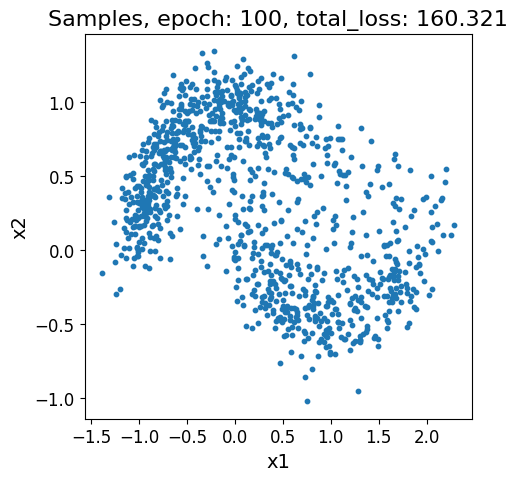

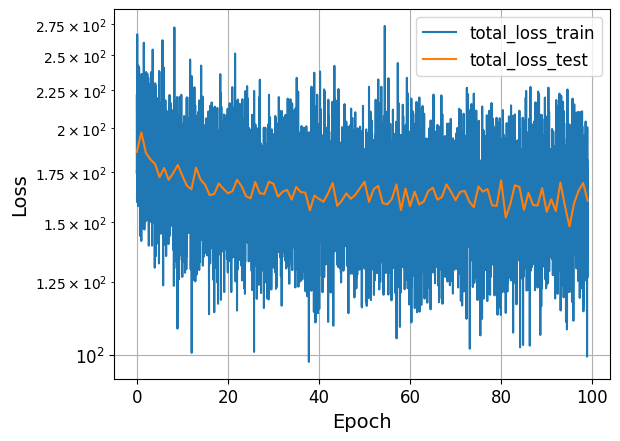

End of the training


In [54]:
# ====
# your code
# choose these parameters
BATCH_SIZE  = 64
EPOCHS      = 100
LR          = 0.005
HIDDEN_SIZE = 64
SIGMA = 0.1
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# ====
# your code
# define sequential model
# it is enough to use the sequence of Linear layers with activations
score_model = nn.Sequential(nn.Linear(2, HIDDEN_SIZE), nn.ReLU(),
                            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE), nn.ReLU(),
                            nn.Linear(HIDDEN_SIZE, 2)
                            )
# ====

matcher = DenoisingScoreMatcher(
    score_model=score_model, input_shape=(2,), sigma=SIGMA
)

# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(matcher.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

train_model(
    matcher,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    n_samples=1024,
    visualize_samples=True,
    logscale_y=True,
)

Let sample from our model. Experiment with number of steps and $\eta$ for Langevin dynamics.

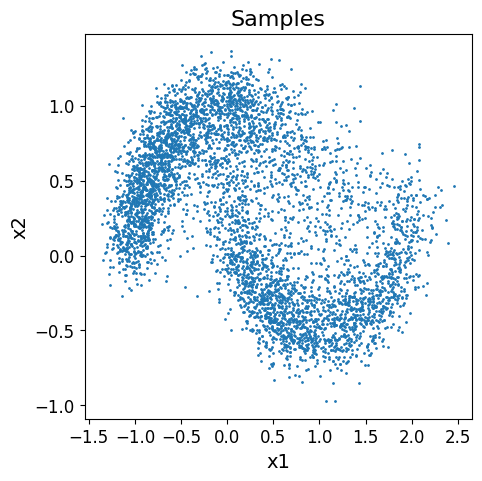

In [55]:
# ====
# your code
# choose these parameters
NUM_STEPS = 100
ETA = 0.01
# ====

samples = matcher.sample(num_samples=5000, num_steps=NUM_STEPS, eta=ETA).cpu()

visualize_2d_samples(samples, title="Samples", s=1)

## Task 3: Noise Conditioned Score Network for MNIST (5 pts)

Now we try to extend our model to the NCSN. It means that we have to add multiple noise scales.

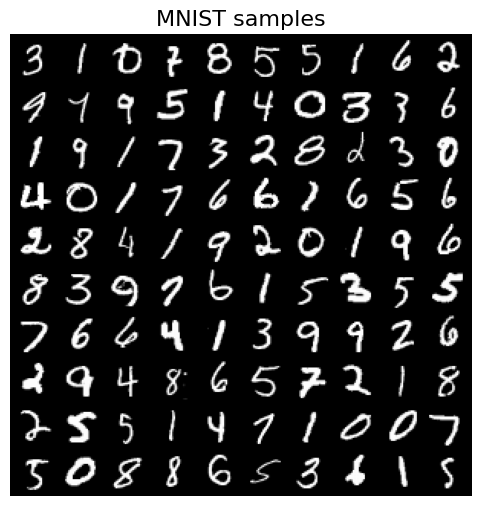

In [74]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=False)
visualize_images(train_data, "MNIST samples")

train_data, test_data = 2 * train_data - 1, 2 * test_data - 1

Here we will use the resnet-like architecture. But we encourage you to experiment with it.

The important thing here is the conditioning of the score model to noise. It means that the noise scale $\sigma$ have to be the input of the model. We will use embedding layer to make this conditioning.

In [75]:
class ConditionedResnetBlock(nn.Module):
    def __init__(self, dim: int, num_embeddings: int) -> None:
        super().__init__()
        # you could experiment with this architecture
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=1),
        )
        self.dim = dim
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=dim)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        time_embed = self.embedding(y).view(-1, self.dim, 1, 1)
        return x + self.block(x + time_embed)


class ConditionedSimpleResnet(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, n_filters: int, n_blocks: int, num_embeddings: int
    ) -> None:
        super().__init__()
        # you could experiment with this architecture
        self.first_block = nn.Sequential(
            nn.Conv2d(in_channels, n_filters, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.layers = nn.Sequential(*[ConditionedResnetBlock(n_filters, num_embeddings) for _ in range(n_blocks)])
        self.last_block = nn.Sequential(
            nn.ReLU(), nn.Conv2d(n_filters, out_channels, kernel_size=3, padding=1)
        )
        self.n_filters = n_filters

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        x = self.first_block(x)
        for layer in self.layers:
            x = layer(x, y)
        x = self.last_block(x)
        return x


def test_conditioned_resnet():
    model = ConditionedSimpleResnet(in_channels=1, out_channels=1, n_filters=16, n_blocks=1, num_embeddings=2)
    x = torch.rand((1, 1, 28, 28))
    y = torch.zeros(size=(1,), dtype=torch.long)
    out1 = model(x, y)
    y = torch.ones(size=(1,), dtype=torch.long)
    out2 = model(x, y)
    assert not np.allclose(out1.detach().numpy(), out2.detach().numpy())


test_conditioned_resnet()

Now lets define the main model.

We will use the sequence of the noise levels: $\sigma_1 < \sigma_2 < \dots < \sigma_T$. In this task it will be the geometric progression.
And we will perturb the original data with the different noise levels to obtain
$$
\mathbf{x}_t = \mathbf{x} + \sigma_t \cdot \boldsymbol{\epsilon}, \quad \mathbf{x}_t \sim q(\mathbf{x}_t).
$$

Our training objective:
$$
    \sum_{t=1}^T \frac{\sigma_t^2}{\sigma_T^2} \mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_t | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma_t}(\mathbf{x}_t) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_t | \mathbf{x}) \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}
$$
But instead of doing the honest summation we will sample one timestamp for each sample.

We will use annealed Langevin dynamics to sample from our model:
1. Sample $\mathbf{x}_0 \sim \mathcal{N}(0, \sigma_T^2 \cdot \mathbf{I}) \approx q(\mathbf{x}_T)$.
2. Apply $L$ steps of Langevin dynamic
$$
    \mathbf{x}_l = \mathbf{x}_{l-1} + \frac{\eta_t}{2} \cdot \mathbf{s}_{\boldsymbol{\theta}, \sigma_t}(\mathbf{x}_{l - 1}) + \sqrt{\eta_t} \cdot \boldsymbol{\epsilon}_l.
$$
3. Update $\mathbf{x}_0 := \mathbf{x}_L$ and choose the next $\sigma_t$.
4. Repeat it for all sigmas.

**Note:** use the following formula for $\eta_t = \epsilon \cdot \frac{\sigma_t^2}{\sigma_T^2}$ ($\epsilon$ is a small number that is a hyperparameter of the sampling).

In [76]:
torch.randint(low=0, high=1, size=(4,))

tensor([0, 0, 0, 0])

In [101]:
class NoiseConditionedScoreNetwork(BaseModel):
    def __init__(
            self,
            score_model: nn.Module,
            input_shape: Tuple[int],
            sigmas: List[float]
        ):
        super().__init__()

        self.score_model = score_model
        self.input_shape = input_shape
        self.sigmas = torch.FloatTensor(sorted(sigmas, reverse=True))

    def forward(self, x: torch.Tensor):
        self.sigmas = self.sigmas.to(self.device)
        batch_size = x.shape[0]
        # ====
        # your code
        # sample gaussian noise
        # sample timestamps for each datapoint in the batch
        # choose sigmas for these datapoints
        # add noises to the x samples
        noise = torch.randn_like(x)
        timestamps = torch.randint(low=0, high=self.sigmas.shape[0], size=(batch_size,), device=x.device)
        which_sigmas = self.sigmas[timestamps].reshape((noise.shape[0],) + (1,) * (noise.ndim - 1))
        noisy_x = x + which_sigmas * noise
        # =====

        # calculate the score model
        s = self.score_model(noisy_x, timestamps)

        # ====
        # your code
        # compute the loss
        # it is mse between score function and gradient of the normal distribution (do not forget the coefficient before the mse)
        sigma_coef = which_sigmas / self.sigmas[0]
        loss = nn.functional.mse_loss(sigma_coef * s, -noise / self.sigmas[0], reduction='none')
        # =====
        return loss

    def loss(self, x: torch.Tensor):
        return {"total_loss": self(x).mean(dim=0).sum()}

    def annealed_langevin_dynamics(self, x: torch.Tensor, num_steps: int, eps: float):
        # =====
        # your code
        # here we will have 2 cycles: one for sigmas, one for Langevin sampling
        # start with the largest sigma, apply Langevin dynamic for it and move to the next sigma
        for timestamp, sigma in enumerate(self.sigmas.to(x.device)):
            mu = eps * sigma ** 2 / self.sigmas[0] ** 2
            for step in range(num_steps):
                x += mu / 2 * self.score_model(x, torch.tensor(timestamp).to(x.device)) + torch.sqrt(mu) * torch.randn_like(x)
        # =====
        return x
    @torch.no_grad()
    def sample(self, num_samples: int = 64, num_steps: int=100, eps: float = 0.1):
        # we sample x_0 from U[-1, 1]
        x0 = 2. * torch.rand_like(torch.empty(num_samples, *self.input_shape)) - 1.
        x0 = x0.to(self.device)

        # run langevine dynamics
        x = self.annealed_langevin_dynamics(x0, num_steps=num_steps, eps=eps)
        return (x.clip(-1., 1) + 1) / 2


def test_ncsn():
    class DummyConditionedMLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.layer = nn.Linear(2, 2)

        def forward(self, x: torch.Tensor, y: torch.Tensor):
            y = y.view(-1, 1)
            return self.layer(x) + y


    ncsn = NoiseConditionedScoreNetwork(
        score_model=DummyConditionedMLP(),
        input_shape=(2,),
        sigmas=[0.1]
    )
    x = torch.rand(16, 2)
    assert x.size() == ncsn(x).size()
    loss = ncsn.loss(x)["total_loss"]
    assert len(loss.size()) == 0
    assert list(ncsn.sample(4).size()) == [4, 2]


test_ncsn()

Epoch: 2, loss: 6.445238187623176


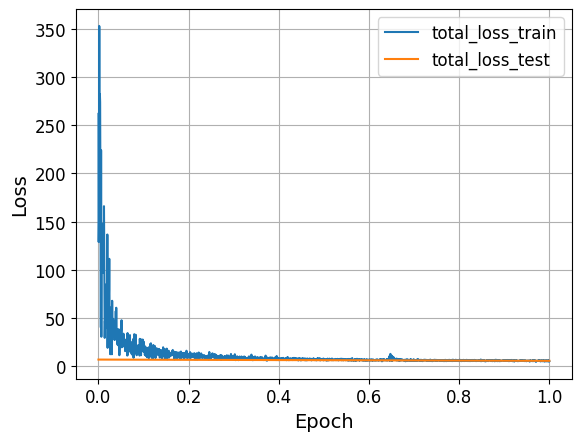

Training epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 64
LR = 0.0001
EPOCHS = 10
N_FILTERS = 32
N_BLOCKS = 10

sigma_max = 10.0
sigma_min = 0.01
L = 20
SIGMAS = torch.exp(torch.linspace(torch.log(torch.tensor(sigma_min)), torch.log(torch.tensor(sigma_max)), L))
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

score_model = ConditionedSimpleResnet(
     in_channels=1, out_channels=1, n_filters=N_FILTERS, n_blocks=N_BLOCKS, num_embeddings=len(SIGMAS)
)

ncsn = NoiseConditionedScoreNetwork(
    score_model=score_model, input_shape=(1, 28, 28), sigmas=SIGMAS,
)

# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(ncsn.parameters(), lr=LR)

# train
train_model(
    ncsn,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    n_samples=16,
    visualize_samples=False
)

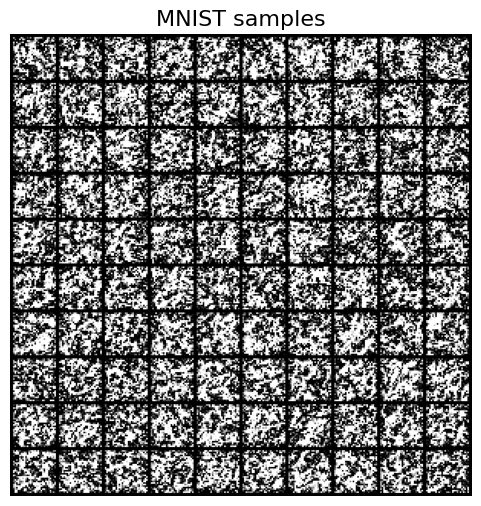

In [108]:
# ====
# your code
# choose these parameters
NUM_STEPS = 50
EPS = 1
# ====

samples = ncsn.sample(100, num_steps=NUM_STEPS, eps=EPS).cpu()
show_samples(samples, "MNIST samples")